In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# load data

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import random
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
def load_segmentation_data(img_paths, mask_paths, shape=256):
    """Load and preprocess image and mask data"""
    images = []
    masks = []
    classes = []

    file_pairs_arr = []
    # Get image names
    for img_path in img_paths:
        img_names = os.listdir(img_path)
        base_names = list(set(name.split(')')[0] for name in img_names))
        file_pairs = [(f"{base}).png", f"{base})_mask.png") for base in base_names]
        file_pairs_arr.append(file_pairs)

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((shape, shape)),
        transforms.ToTensor()
    ])

    for i,file_pairs in enumerate(file_pairs_arr):
        for img_name, mask_name in file_pairs:
            img = Image.open(os.path.join(img_paths[i], img_name)).convert('L')
            mask = Image.open(os.path.join(mask_paths[i], mask_name)).convert('L')

            img_tensor = transform(img)
            mask_tensor = transform(mask)

            images.append(img_tensor)
            masks.append(mask_tensor)
            classes.append(torch.tensor(i))

    return torch.stack(images), torch.stack(masks), torch.stack(classes)

In [4]:
class CustomDataset(Dataset):
    """Custom dataset for breast cancer segmentation"""

    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

In [5]:
class AugmentedDataset(Dataset):
    """Custom dataset with torchvision augmentations for breast cancer segmentation"""
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks
        self.train = train

        # Basic normalization and conversion
        self.normalize = transforms.Normalize(mean=[0.485], std=[0.229])

        # Training augmentations
        self.train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomAffine(
                degrees=30,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1),
                fill=0
            ),
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2
            )
        ])

    def __len__(self):
        return len(self.images)

    def apply_transforms_to_both(self, image, mask):
        """Apply same spatial transforms to both image and mask"""
        # Convert to PIL Image for transforms
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        if isinstance(mask, torch.Tensor):
            mask = transforms.ToPILImage()(mask)

        # Generate random values for transforms
        if random.random() < 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        if random.random() < 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)

        if random.random() < 0.5:
            angle = random.uniform(-30, 30)
            image = transforms.functional.rotate(image, angle, fill=0)
            mask = transforms.functional.rotate(mask, angle, fill=0)

        if random.random() < 0.5:
            scale = random.uniform(0.9, 1.1)
            trans_x = random.uniform(-0.1, 0.1)
            trans_y = random.uniform(-0.1, 0.1)

            width, height = image.size
            max_dx = trans_x * width
            max_dy = trans_y * height
            translations = (np.round(random.uniform(-max_dx, max_dx)),
                          np.round(random.uniform(-max_dy, max_dy)))

            image = transforms.functional.affine(image, 0, translations, scale, 0, fill=0)
            mask = transforms.functional.affine(mask, 0, translations, scale, 0, fill=0)

        return image, mask

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.train:
            image, mask = self.apply_transforms_to_both(image, mask)

        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
        if not isinstance(mask, torch.Tensor):
            mask = transforms.ToTensor()(mask)

        # Ensure the image has 3 channels
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        image = self.normalize(image)
        return image, mask

In [6]:
def get_data_loaders(images, masks, classes, batch_size):
    """Create data loaders with augmentation and stratification"""
    # First split: separate test set
    X_train_val, X_test, y_train_val, y_test, classes_train_val, _ = train_test_split(
        images, masks, classes,
        test_size=0.2,  # 20% for test
        random_state=42,
        stratify=classes
    )

    # Second split: separate train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=0.125,  # 10% of total (0.125 of 80% = 10% of total)
        random_state=42,
        stratify=classes_train_val
    )

    # Create datasets
    train_dataset = AugmentedDataset(X_train, y_train, train=True)
    val_dataset = AugmentedDataset(X_val, y_val, train=False)
    test_dataset = AugmentedDataset(X_test, y_test, train=False)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

In [7]:
# IoU Calculation
def calculate_iou(preds, targets, threshold=0.5, device='cpu'):
    """Calculates IoU score"""
    # Convert to PyTorch tensors if necessary
    if not isinstance(preds, torch.Tensor):
        preds = torch.tensor(preds, dtype=torch.float32, device=device)
    if not isinstance(targets, torch.Tensor):
        targets = torch.tensor(targets, dtype=torch.float32, device=device)

    # Ensure both tensors are on the same device
    preds = preds.to(device)
    targets = targets.to(device)
        
    preds = (preds > threshold).float()  # Apply threshold to get binary mask
    intersection = torch.sum(preds * targets)
    union = torch.sum(preds) + torch.sum(targets) - intersection
    iou = intersection / (union + 1e-6)  # Add small epsilon to avoid division by zero
    return iou

In [8]:
TEST_SPLIT = 0.2          # Validation split ratio
VAL_SPLIT = 0.875         # 10/80 after test split
RANDOM_SEED = 42          # Random seed for reproducibility
# IMAGE_SIZE = 256          # Input image size
BATCH_SIZE = 16           # Batch size for training
# LEARNING_RATE = 0.001     # Initial learning rate
# WEIGHT_DECAY = 1e-6       # Weight decay for regularization
NUM_EPOCHS = 50           # Number of training epochs

# # Set device (GPU/CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
root_data_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
data_paths = [root_data_path+'normal', root_data_path+'benign', root_data_path+'malignant']
images, masks, classes = load_segmentation_data(data_paths, data_paths)

train_loader, val_loader, test_loader = get_data_loaders(
    images=images,
    masks=masks,
    classes=classes,
    batch_size=BATCH_SIZE
)

# load UNet

In [11]:
def unet_evaluation(model, test_loader, device):
    predicted_masks = []
    # original_masks = []
    ious = []

    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images = torch.mean(images, dim=1, keepdim=True)
                
            images = images.to(device)
            masks = masks.to(device)
            predictions = model(images)
            
            # Convert tensors to numpy arrays
            image = images[0].cpu().numpy().squeeze()
            mask = masks[0].cpu().numpy().squeeze()
            pred = predictions[0].cpu().numpy().squeeze()

            predicted_masks.append(pred)
            # original_masks.append(mask)

            this_iou = calculate_iou(pred, mask)
            ious.append(this_iou)

    mean_iou = np.mean(np.array(ious))
    return predicted_masks, mean_iou

In [12]:
class Conv2dBlock(nn.Module):
    """Basic convolutional block for UNet"""
    def __init__(self, in_channels, out_channels, kernel_size=3, do_batch_norm=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.batch_norm1 = nn.BatchNorm2d(out_channels) if do_batch_norm else nn.Identity()
        self.batch_norm2 = nn.BatchNorm2d(out_channels) if do_batch_norm else nn.Identity()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        return x

In [13]:
class UNet(nn.Module):
    """UNet architecture for image segmentation"""
    def __init__(self, in_channels=1, num_filters=16, dropout=0.1, do_batch_norm=True):
        super().__init__()
        
        # Encoder
        self.conv1 = Conv2dBlock(in_channels, num_filters, do_batch_norm=do_batch_norm)
        self.conv2 = Conv2dBlock(num_filters, num_filters*2, do_batch_norm=do_batch_norm)
        self.conv3 = Conv2dBlock(num_filters*2, num_filters*4, do_batch_norm=do_batch_norm)
        self.conv4 = Conv2dBlock(num_filters*4, num_filters*8, do_batch_norm=do_batch_norm)
        
        # Bridge
        self.bridge = Conv2dBlock(num_filters*8, num_filters*16, do_batch_norm=do_batch_norm)
        
        # Decoder
        self.up_conv4 = nn.ConvTranspose2d(num_filters*16, num_filters*8, kernel_size=2, stride=2)
        self.conv6 = Conv2dBlock(num_filters*16, num_filters*8, do_batch_norm=do_batch_norm)
        
        self.up_conv3 = nn.ConvTranspose2d(num_filters*8, num_filters*4, kernel_size=2, stride=2)
        self.conv7 = Conv2dBlock(num_filters*8, num_filters*4, do_batch_norm=do_batch_norm)
        
        self.up_conv2 = nn.ConvTranspose2d(num_filters*4, num_filters*2, kernel_size=2, stride=2)
        self.conv8 = Conv2dBlock(num_filters*4, num_filters*2, do_batch_norm=do_batch_norm)
        
        self.up_conv1 = nn.ConvTranspose2d(num_filters*2, num_filters, kernel_size=2, stride=2)
        self.conv9 = Conv2dBlock(num_filters*2, num_filters, do_batch_norm=do_batch_norm)
        
        self.output = nn.Conv2d(num_filters, 1, kernel_size=1)
        
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder path
        c1 = self.conv1(x)
        p1 = self.dropout(self.maxpool(c1))
        
        c2 = self.conv2(p1)
        p2 = self.dropout(self.maxpool(c2))
        
        c3 = self.conv3(p2)
        p3 = self.dropout(self.maxpool(c3))
        
        c4 = self.conv4(p3)
        p4 = self.dropout(self.maxpool(c4))
        
        # Bridge
        bridge = self.bridge(p4)
        
        # Decoder path
        up4 = self.up_conv4(bridge)
        merge4 = torch.cat([up4, c4], dim=1)
        c6 = self.conv6(self.dropout(merge4))
        
        up3 = self.up_conv3(c6)
        merge3 = torch.cat([up3, c3], dim=1)
        c7 = self.conv7(self.dropout(merge3))
        
        up2 = self.up_conv2(c7)
        merge2 = torch.cat([up2, c2], dim=1)
        c8 = self.conv8(self.dropout(merge2))
        
        up1 = self.up_conv1(c8)
        merge1 = torch.cat([up1, c1], dim=1)
        c9 = self.conv9(self.dropout(merge1))
        
        output = self.sigmoid(self.output(c9))
        return output

In [14]:
unet_path = '/kaggle/input/unet-breast-cancer/pytorch/gavin/1/unet_best_breast_cancer_model.pth'

# unet = model.load_state_dict(torch.load(unet_path, map_location=device)))
# unet_model = unet.to(device)
unet_model = UNet()
checkpoint = torch.load(unet_path, map_location=device)
# unet_model.load_state_dict(checkpoint['model_state_dict'])
unet_model.load_state_dict(checkpoint)

unet_model.to(device)
unet_model.eval()

/tmp/ipykernel_30/1378001767.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(unet_path, map_location=device)


UNet(
  (conv1): Conv2dBlock(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): Conv2dBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv3): Conv2dBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batch_norm1): 

In [15]:
unet_pred_masks, unet_iou = unet_evaluation(unet_model, test_loader, device)

In [16]:
unet_iou

0.5276549

# load Deeplabv3

In [17]:
def dlv3_evaluation(model, test_loader, device):
    predicted_masks = []
    # original_masks = []
    ious = []

    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
                
            images = images.to(device)
            masks = masks.to(device)
            predictions = model(images)
            
            # Convert tensors to numpy arrays
            image = images[0].cpu().numpy().squeeze()
            mask = masks[0].cpu().numpy().squeeze()
            pred = predictions['out'][0].cpu().numpy().squeeze()

            predicted_masks.append(pred)
            # original_masks.append(mask)

            this_iou = calculate_iou(pred, mask)
            ious.append(this_iou)

    mean_iou = np.mean(np.array(ious))
    return predicted_masks, mean_iou

In [18]:
# model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, num_classes=3)
dlv3_model = models.segmentation.deeplabv3_resnet101(pretrained=False)
dlv3_model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1))
# dlv3_model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Load the state_dict
dlv3_state_dict_path = '/kaggle/input/deeplabv3-breast-cancer/pytorch/aman/1/deeplabv3_breast_cancer_model.pth'
# dlv3_model.load_state_dict(torch.load(dlv3_state_dict_path))

# Load the state_dict with filtering
dlv3_state_dict = torch.load(dlv3_state_dict_path)
# Filter out keys related to aux_classifier
filtered_state_dict = {k: v for k, v in dlv3_state_dict.items() if not k.startswith('aux_classifier.')}
# Load filtered state_dict
dlv3_model.load_state_dict(filtered_state_dict, strict=False)  # Use strict=False to allow partial loading

dlv3_model.to(device)
# Set the model to evaluation mode
dlv3_model.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 215MB/s] 
/tmp/ipykernel_30/3698939565.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.c

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [201]:
dlv3_pred_masks, dlv3_iou = dlv3_evaluation(dlv3_model, test_loader, device)

In [202]:
dlv3_iou

0.61695075

In [96]:
# unet_pred_masks[0], unet_pred_masks[0].shape
# unet_pred_masks[0].min(), unet_pred_masks[0].max(), unet_pred_masks[0].mean()

In [95]:
# dlv3_pred_masks[0], dlv3_pred_masks[0].shape
# dlv3_pred_masks[0].min(), dlv3_pred_masks[0].max(), dlv3_pred_masks[0].mean()

# ensemble method

## average based ensemble

In [158]:
import torch
import numpy as np

def ensemble_predictions_v2(unet_model, dlv3_model, dataloader, device):
    unet_model.eval()
    dlv3_model.eval()
    
    ensembled_predictions = []
    all_masks = []
    # ious = []
    # _dlv3_preds = []
    # _unet_preds = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            unet_imgs = torch.mean(images, dim=1, keepdim=True)
            unet_imgs = unet_imgs.to(device)

            # Get predictions from each model
            unet_preds = unet_model(unet_imgs)  # UNet outputs probabilities
            dlv3_preds = dlv3_model(images)  # DeepLabV3 outputs logits

            # Convert predictions to numpy arrays
            unet_preds_np = unet_preds.cpu().numpy()
            dlv3_preds_np = dlv3_preds['out'].cpu().numpy()

            # Dynamically compute min and max for normalization
            unet_min, unet_max = unet_preds_np.min(), unet_preds_np.max()
            dlv3_min, dlv3_max = dlv3_preds_np.min(), dlv3_preds_np.max()

            # Normalize predictions to [0, 1]
            unet_preds_norm = (unet_preds_np - unet_min) / (unet_max - unet_min + 1e-8)
            dlv3_preds_norm = (dlv3_preds_np - dlv3_min) / (dlv3_max - dlv3_min + 1e-8)

            # Ensemble predictions by averaging
            ensembled_pred = (unet_preds_norm + dlv3_preds_norm) / 2

            # Apply a threshold to create binary masks (e.g., threshold = 0.5)
            ensembled_mask = (ensembled_pred > 0.5).astype(np.uint8)

            # Store the results
            ensembled_predictions.extend(ensembled_mask)
            all_masks.extend(masks.cpu().numpy())
            
            # _dlv3_preds.extend((dlv3_preds, dlv3_preds_norm))
            # _unet_preds.extend((unet_preds, unet_preds_norm))
            

    # return ensembled_predictions, all_masks, _dlv3_preds, _unet_preds
    return ensembled_predictions, all_masks

In [159]:
# ensemble_preds, ensemble_iou = ensemble_predictions(unet_model, dlv3_model, test_loader, device)
# ensemble_preds, all_masks = ensemble_predictions(unet_model, dlv3_model, test_loader, device)
# ensemble_preds, all_masks, _dlv3_preds, _unet_preds = ensemble_predictions(unet_model, dlv3_model, test_loader, device)

# ensemble_preds, all_masks, _dlv3_preds, _unet_preds = ensemble_predictions_v2(unet_model, dlv3_model, test_loader, device)
ensemble_preds, all_masks = ensemble_predictions_v2(unet_model, dlv3_model, test_loader, device)

In [160]:
import numpy as np

def evaluate_iou_v2(predictions, ground_truths, threshold=0.5):
    assert len(predictions) == len(ground_truths), "Number of predictions and ground truths must match."

    iou_scores = []

    for pred, gt in zip(predictions, ground_truths):
        # Ensure ground truth is binary
        gt_binary = (gt > 0).astype(np.uint8)
        
        # Threshold predictions if they are probabilities
        pred_binary = (pred > threshold).astype(np.uint8)
        
        # Compute intersection and union
        intersection = np.logical_and(pred_binary, gt_binary).sum()
        union = np.logical_or(pred_binary, gt_binary).sum()

        # Avoid division by zero
        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / union

        iou_scores.append(iou)

    # Compute mean IoU across all predictions
    mean_iou = np.mean(iou_scores)

    return mean_iou, iou_scores


In [161]:
ensemble_mean_iou, ensemble_iou_scores = evaluate_iou_v2(ensemble_preds, all_masks)

In [162]:
ensemble_mean_iou

0.645473153918772

## confidence based ensemble

In [198]:
def combine_unet_deeplabv3_v2(unet_model, deeplabv3_model, dataloader, threshold=0.6):
    unet_model.eval()
    dlv3_model.eval()
    
    combined_preds = []
    all_masks = []

    with torch.no_grad():
        for k, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            unet_imgs = torch.mean(images, dim=1, keepdim=True)
            unet_imgs = unet_imgs.to(device)

            # Get predictions from each model
            unet_preds = unet_model(unet_imgs)  # UNet outputs probabilities
            dlv3_preds = dlv3_model(images)  # DeepLabV3 outputs logits

            # Convert predictions to numpy arrays
            unet_preds_np = unet_preds.cpu().numpy()
            dlv3_preds_np = dlv3_preds['out'].cpu().numpy()

            # Dynamically compute min and max for normalization
            unet_min, unet_max = unet_preds_np.min(), unet_preds_np.max()
            dlv3_min, dlv3_max = dlv3_preds_np.min(), dlv3_preds_np.max()

            # Normalize predictions to [0, 1]
            unet_preds_norm = (unet_preds_np - unet_min) / (unet_max - unet_min + 1e-8)
            dlv3_preds_norm = (dlv3_preds_np - dlv3_min) / (dlv3_max - dlv3_min + 1e-8)

            confidence_threshold = 0.6
            
            # Ensure predictions are 3D (batch_size, height, width)
            unet_preds_norm = unet_preds_norm[:, 0, :, :] if unet_preds_norm.ndim == 4 else unet_preds_norm
            dlv3_preds_norm = dlv3_preds_norm[:, 0, :, :] if dlv3_preds_norm.ndim == 4 else dlv3_preds_norm
            
            # Validate shapes
            assert unet_preds_norm.shape == dlv3_preds_norm.shape, \
                f"Shape mismatch: UNet {unet_preds_norm.shape}, DeepLabV3 {dlv3_preds_norm.shape}"
            
            # Combine predictions
            final_preds = np.where(dlv3_preds_norm > confidence_threshold, 1, unet_preds_norm > 0.5).astype(np.uint8)

            combined_preds.extend(final_preds)
            all_masks.extend(masks.cpu().numpy())
            
    return combined_preds, all_masks


In [199]:
combined_preds, all_masks = combine_unet_deeplabv3_v2(unet_model, dlv3_model, test_loader)

In [200]:
combined_iou = combined_eval(combined_preds, all_masks)
combined_iou

0.488178

# visualisation

In [211]:
def visualize_predictions(test_loader, true_masks, unet_preds, dlv3_preds, ensemble_preds, combined_preds, device):
    """
    Visualize the first 10 test images alongside true masks and predictions.

    Args:
        test_loader (DataLoader): PyTorch DataLoader for the test dataset.
        true_masks (list of np.ndarray): List of true masks (shape can be (1, H, W) or (H, W)).
        unet_preds (list of np.ndarray): List of UNet predictions.
        dlv3_preds (list of np.ndarray): List of DeepLabV3 predictions.
        ensemble_preds (list of np.ndarray): List of ensemble predictions.
        combined_preds (list of np.ndarray): List of confidence-based combined predictions.
        device (torch.device): The device to process data (CPU/GPU).
    """
    num_samples = 10  # Number of images to visualize
    fig, axes = plt.subplots(num_samples, 6, figsize=(18, 3 * num_samples))
    fig.suptitle("Image, True Mask, and Predictions", fontsize=16)

    for idx, (images, masks) in enumerate(test_loader):
        if idx >= num_samples:
            break

        # Move images to CPU and convert to numpy
        images = images.to(device).cpu().numpy()
        masks = masks.to(device).cpu().numpy()

        # Extract the first sample in the batch
        image = np.transpose(images[0], (1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        true_mask = np.squeeze(true_masks[idx])  # Remove singleton dimension if present
        unet_pred = unet_preds[idx]
        dlv3_pred = dlv3_preds[idx]
        ensemble_pred = np.squeeze(ensemble_preds[idx])  # Remove singleton dimension if present
        combined_pred = combined_preds[idx]

        # Plot the row
        axes[idx, 0].imshow(image)  # Original image
        axes[idx, 0].set_title("Image")
        axes[idx, 1].imshow(true_mask, cmap='gray')  # True mask
        axes[idx, 1].set_title("True Mask")
        axes[idx, 2].imshow(unet_pred, cmap='gray')  # UNet prediction
        axes[idx, 2].set_title("UNet Prediction")
        axes[idx, 3].imshow(dlv3_pred, cmap='gray')  # DeepLabV3 prediction
        axes[idx, 3].set_title("DeepLabV3 Prediction")
        axes[idx, 4].imshow(ensemble_pred, cmap='gray')  # Ensemble prediction
        axes[idx, 4].set_title("Ensemble Prediction")
        axes[idx, 5].imshow(combined_pred, cmap='gray')  # Confidence-based combined prediction
        axes[idx, 5].set_title("Combined Prediction")

        # Remove axes for clarity
        for ax in axes[idx]:
            ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

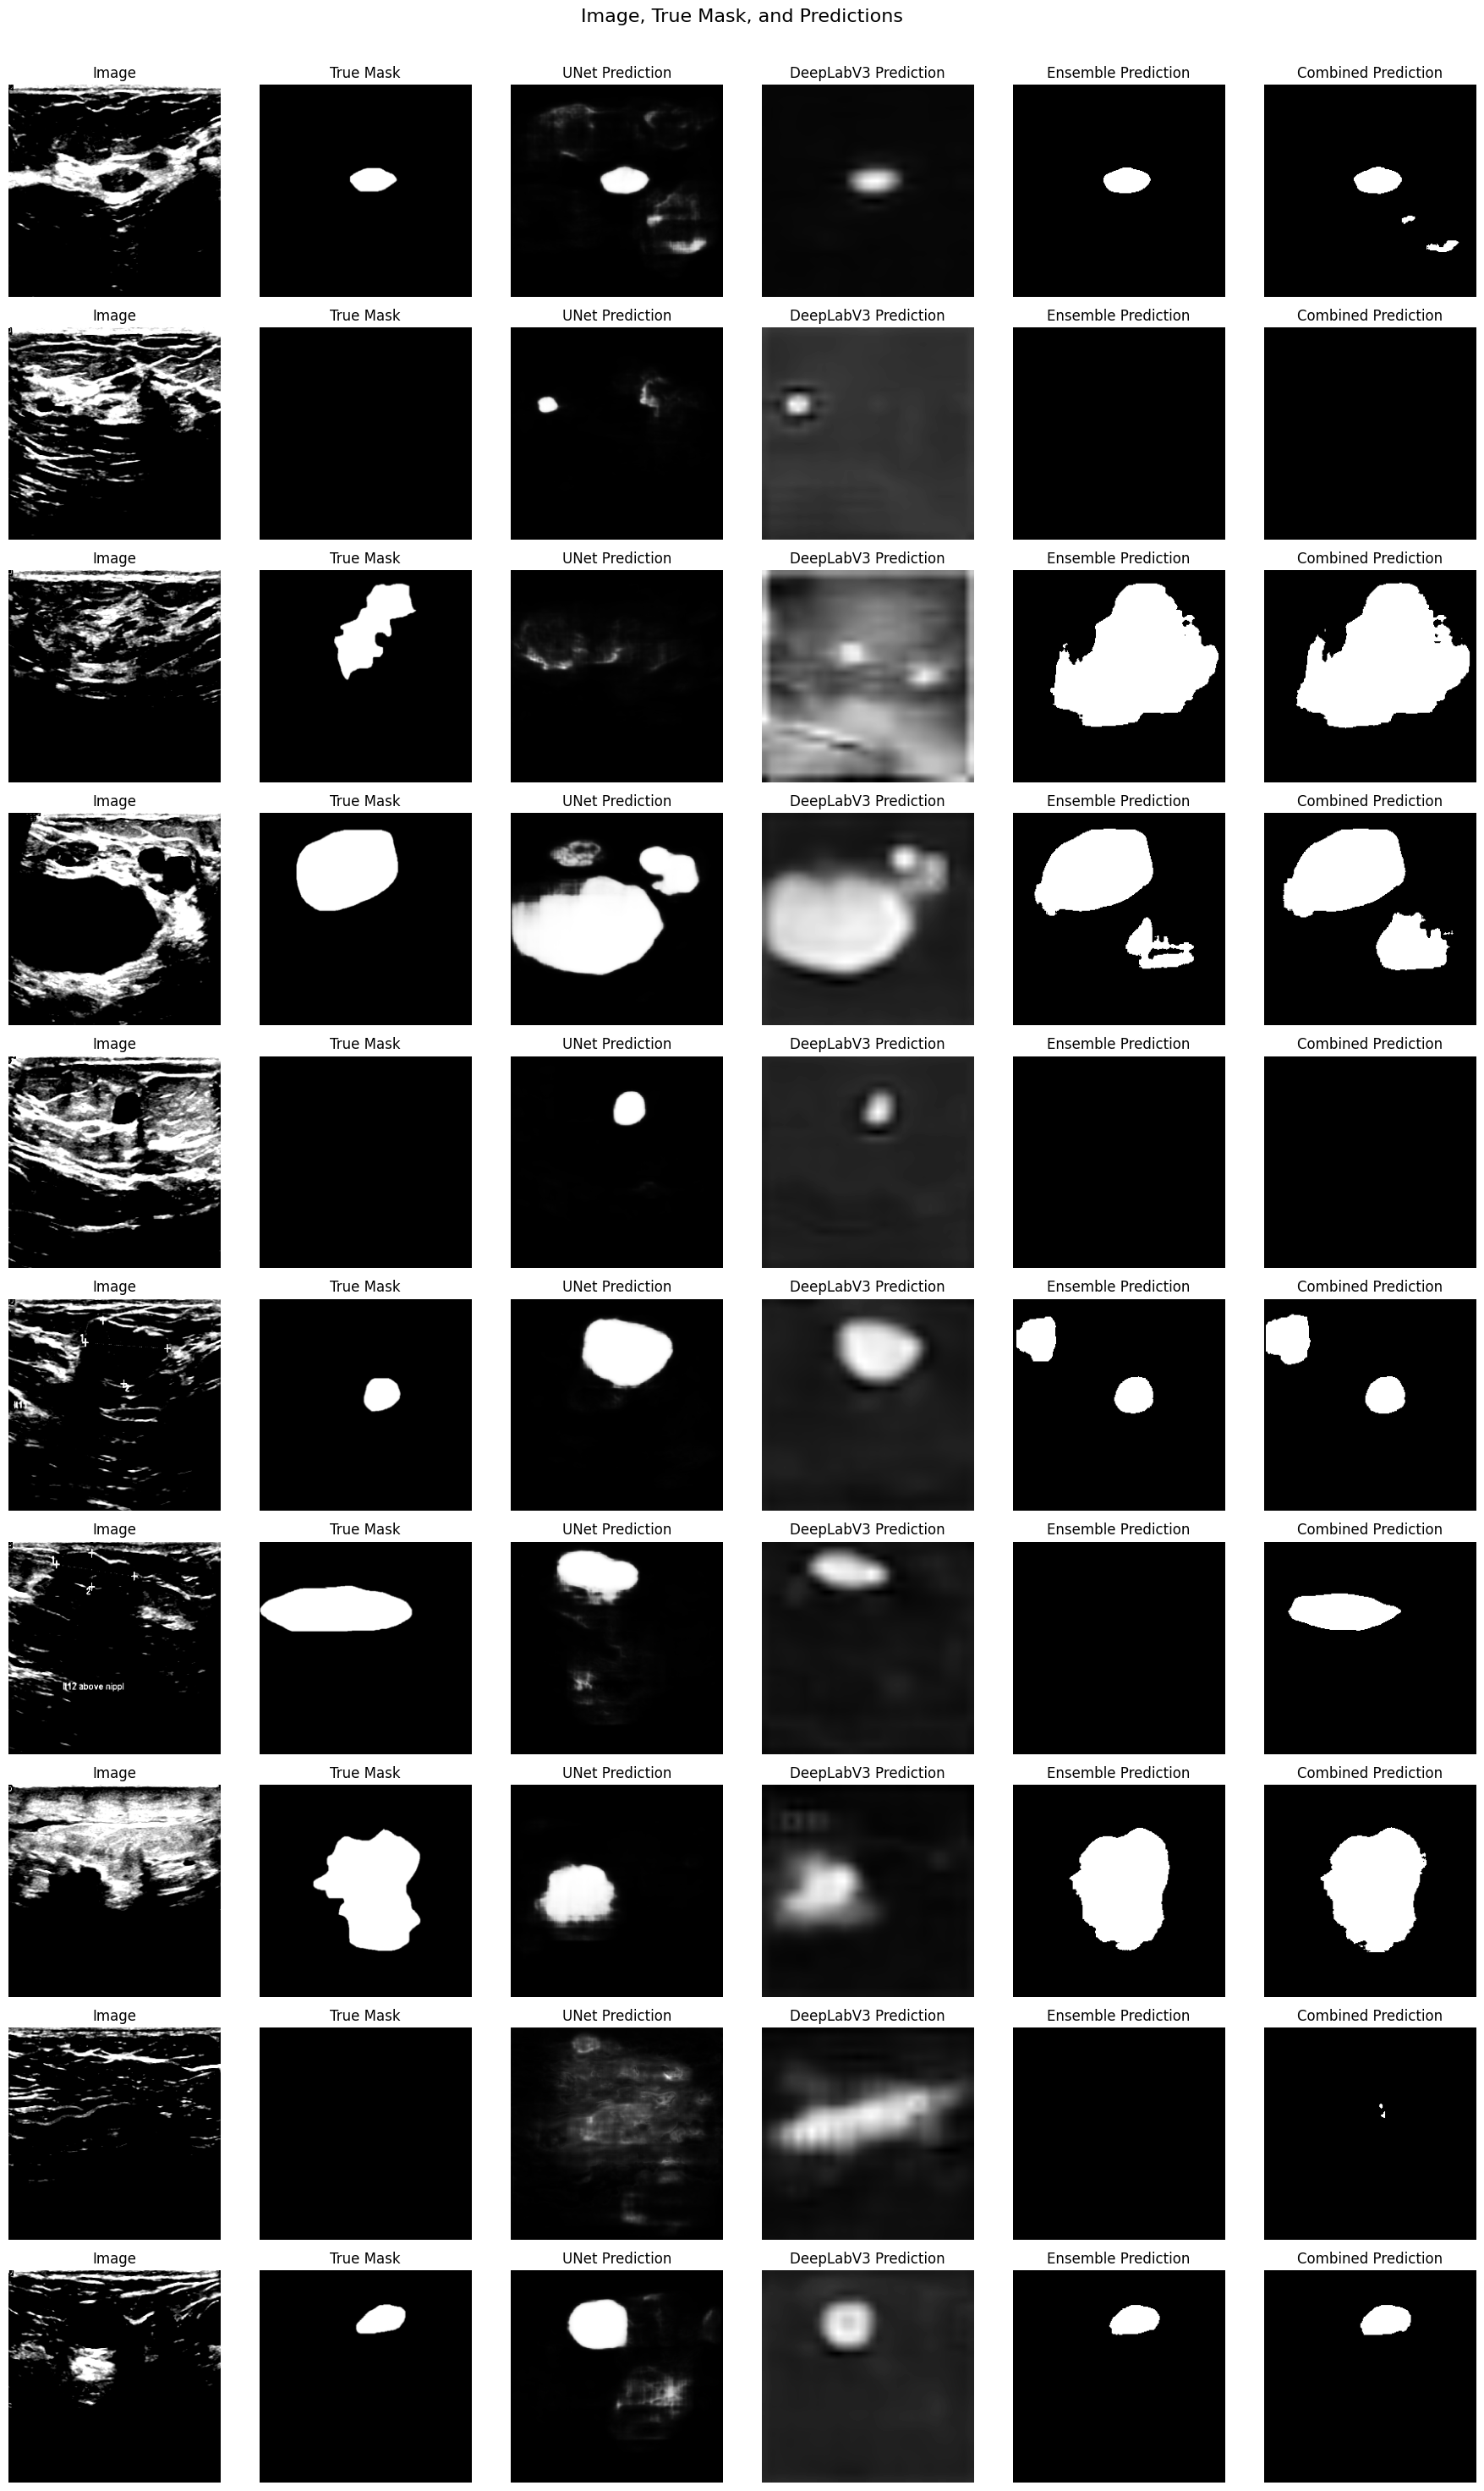

In [213]:
# Example usage
visualize_predictions(
    test_loader=test_loader,
    true_masks=all_masks,
    unet_preds=unet_pred_masks,
    dlv3_preds=dlv3_pred_masks,
    ensemble_preds=ensemble_preds,
    combined_preds=combined_preds,
    device=device
)

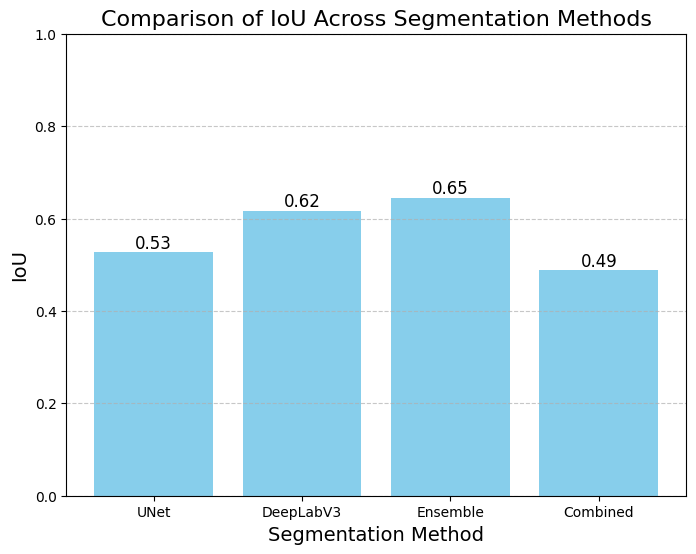

In [215]:
# Example IoU values
iou_values = [unet_iou, dlv3_iou, ensemble_mean_iou, combined_iou]  # Replace with your actual IoU values
methods = ['UNet', 'DeepLabV3', 'Ensemble', 'Combined']

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(methods, iou_values, color='skyblue')

# Add values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate of the text
        height,  # Y-coordinate of the text
        f'{height:.2f}',  # Format the value to two decimal places
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=12  # Font size
    )

# Add labels and title
plt.xlabel('Segmentation Method', fontsize=14)
plt.ylabel('IoU', fontsize=14)
plt.title('Comparison of IoU Across Segmentation Methods', fontsize=16)
plt.ylim(0, 1)  # IoU values range from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# end